# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
from fix_project_dir import fix_project_dir
fix_project_dir()

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from mask_rcnn.util.config import Config
from mask_rcnn.util import utils
from mask_rcnn.model import model as modellib
from mask_rcnn.util import visualize
from mask_rcnn.model.model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

INFO: switched to project_dir: /home/uai/understandai/mask_rcnn


/home/uai/.pyenv/versions/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Configurations

In [4]:
class CityscapesConfig(Config):
    """Configuration for training on the cityscapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cityscapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 20 + 1  # background + actual classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    MEAN_PIXEL = np.array((72.78044, 83.21195, 73.45286))

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100  # TODO

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5  # TODO
    
config = CityscapesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 72.78044  83.21195  73.45286]
MINI_MASK_SHAPE                (56, 56)
NAME                           cityscapes
NUM_CLASSES                    21
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [82]:
from os import path
import scipy
from imageio import imread
from collections import namedtuple
from collections import defaultdict

DATA_FOLDER = '/data/Cityscapes/'
IMAGE_FOLDER = path.join(DATA_FOLDER, 'images')
INSTANCE_FOLDER = path.join(DATA_FOLDER, 'instances')

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'train_id'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!
    
    'train_name'  ,

    'category'    , # The name of the category that this label belongs to

    'category_id'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'has_instances', # Whether this label distinguishes between single instances or not

    'ignore_in_eval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   train_name         category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      1 , 'void'           , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      1 , 'void'           , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      1 , 'void'           , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      1 , 'void'           , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      1 , 'void'           , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      1 , 'void'           , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      1 , 'void'           , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        2 , 'road'           , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        3 , 'sidewalk'       , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      1 , 'void'           , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      1 , 'void'           , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        4 , 'building'       , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        5 , 'wall'           , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        6 , 'fence'          , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      1 , 'void'           , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      1 , 'void'           , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      1 , 'void'           , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        7 , 'pole'           , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      1 , 'void'           , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        8 , 'traffic light'  , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        9 , 'traffic sign'   , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        10 , 'vegetation'     , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,       11 , 'terrain'        , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       12 , 'sky'            , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       13 , 'person'         , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       14 , 'rider'          , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       15 , 'car'            , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       16 , 'truck'          , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       17 , 'bus'            , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      1 , 'void'           , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      1 , 'void'           , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       18 , 'train'          , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       19 , 'motorcycle'     , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       20 , 'bicycle'        , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    # TODO Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# id to trainId
id2train_id     = { label.id      : label.train_id for label in labels           }

class CityscapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_images(self, type):
        """Load cityscapes images.
        type: Subset of the dataset that should be loaded. Can be 'train', 'val' or 'test'.
        """
        assert type in ['train', 'val', 'test']
        
        # Add classes
#         classes = {
#             1: 'ego vehicle',
#             2: 'rectification border',
#             3: 'out of roi',
#             4: 'static',
#             5: 'dynamic',
#             6: 'ground',
#             7: 'road',
#             8: 'sidewalk',
#             9: 'parking',
#             10: 'rail track',
#             11: 'building',
#             12: 'wall',
#             13: 'fence',
#             14: 'guard rail',
#             15: 'bridge',
#             16: 'tunnel',
#             17: 'pole',
#             18: 'polegroup',
#             19: 'traffic light',
#             20: 'traffic sign',
#             21: 'vegetation',
#             22: 'terrain',
#             23: 'sky',
#             24: 'person',
#             25: 'rider',
#             26: 'car',
#             27: 'truck',
#             28: 'bus',
#             29: 'caravan',
#             30: 'trailer',
#             31: 'train',
#             32: 'motorcycle',
#             33: 'bicycle',
#             # TODO -1: 'license plate',
#         }
        
#         for id, name in classes.items():
#             self.add_class("cityscapes", id, name)

        allowed_label_names = [
            'person',
            'rider',
            'car',
            'truck',
            'bus',
            'train',
            'motorcycle',
            'bicycle'
        ]
        allowed_labels = [label for label in labels if label.name in allowed_label_names]

        self.id2internal_id = defaultdict(lambda: -1)
        
        counter = 1
        for label in allowed_labels:
            if label.train_id != 0:
                self.id2internal_id[label.id] = counter
                self.add_class("cityscapes", label.train_id, label.train_name)
                counter += 1

        # Add images
        image_list = path.join(DATA_FOLDER, type + '.txt')
        with open(image_list, "r") as f:
            for count, line in enumerate(f):
                image_id = f'{type}-{count}'
                filename = line.strip()
                image_path = path.join(IMAGE_FOLDER, filename)
                mask_path = path.join(INSTANCE_FOLDER, filename)
                self.add_image("cityscapes", image_id=image_id, path=image_path, mask_path=mask_path)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = imread(info['path'])
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "cityscapes":
            return image_id
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        # TODO don't hardcode
        image_width = 2048
        image_height = 1024
        
        # load instance image
        info = self.image_info[image_id]
        mask = imread(info['mask_path'])
        assert mask.shape == (image_height, image_width)
        
        # extract instances
        instances = np.unique(mask)
        
        # create masks
        expanded_mask = np.expand_dims(mask, axis=2)
        empty_mask = np.zeros(expanded_mask.shape)
        masks = [] # np.repeat(empty_mask, len(instances), axis=2)
        class_ids = []
        for instance_id in instances:
            # ignore background class
            if instance_id == 0:
                continue
            
            # calculate mask
            current_mask = np.copy(expanded_mask)
            current_mask[current_mask != instance_id] = 0
            current_mask[current_mask == instance_id] = 1
            
            # ignore small boxes
            # TODO speed
            scale = 1/2  # TODO don't hardcode
            scaled_mask = scipy.ndimage.zoom(current_mask, zoom=[scale, scale, 1], order=0)
            unique = np.unique(scaled_mask)
            if len(unique) == 1:  # only background
                continue
            
            # calculate class id from instance id
            class_id = instance_id
            divided = False
            if class_id > 1000:
                class_id //= 1000
                divided = True
            
            # convert id to train id to internal id
            c_id = class_id
            class_id = self.id2internal_id[class_id]
            
            # assert class_id in self.class_ids, f'class_id {class_id} not in class_ids: {class_ids} [path: {info["path"]}, divided: {divided}]'
            if class_id in self.class_ids:
                masks.append(current_mask)
                class_ids.append(class_id)
        if masks:
            masks = np.concatenate(masks, axis=2)
        else:
            masks = np.array([]).reshape((image_height, image_width, 0))
        
        assert masks.shape == (image_height, image_width, len(class_ids))
        return masks, np.array(class_ids)


In [83]:
# Training dataset
dataset_train = CityscapesDataset()
dataset_train.load_images('train')
dataset_train.prepare()

# Validation dataset
dataset_val = CityscapesDataset()
dataset_val.load_images('val')
dataset_val.prepare()

Example training images


HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

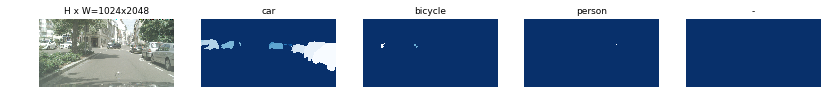

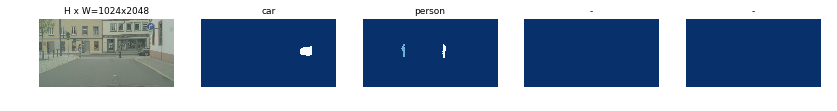


Example validation images


HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

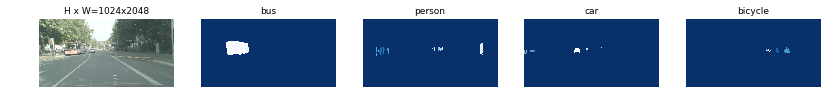

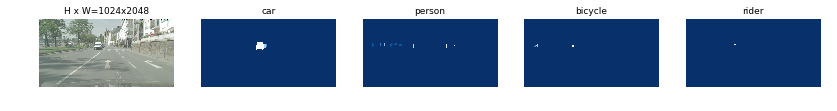

In [84]:
from tqdm import tnrange, tqdm_notebook

do_sanity_check = False
num_train_example_images = 2
num_val_example_images = 2

if do_sanity_check:
    print('Sanity check on validation images')
    image_ids = dataset_val.image_ids
    for image_id in tqdm_notebook(image_ids):
        image = dataset_val.load_image(image_id)
        mask, class_ids = dataset_val.load_mask(image_id)

    print('Sanity check on training images')
    image_ids = dataset_train.image_ids
    for image_id in tqdm_notebook(image_ids):
        image = dataset_train.load_image(image_id)
        mask, class_ids = dataset_train.load_mask(image_id)

# Load and display random samples from train set
print('Example training images')
image_ids = np.random.choice(dataset_train.image_ids, num_train_example_images)
for image_id in tqdm_notebook(image_ids):
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    
# Load and display random samples from val set
print('Example validation images')
image_ids = np.random.choice(dataset_val.image_ids, num_val_example_images)
for image_id in tqdm_notebook(image_ids):
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

## Ceate Model

In [85]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [86]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [87]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
num_epochs = 1
model.train(dataset_train, dataset_val,            
            learning_rate=config.LEARNING_RATE, 
            epochs=num_epochs, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/uai/understandai/mask_rcnn/logs/cityscapes20180123T2135/mask_rcnn_cityscapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

/home/uai/.virtualenvs/keras/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/uai/.virtualenvs/keras/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 386s 4s/step - loss: 2.1112 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.4722 - mrcnn_class_loss: 0.6306 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.4933 - val_loss: 1.4663 - val_rpn_class_loss: 0.0313 - val_rpn_bbox_loss: 0.3555 - val_mrcnn_class_loss: 0.3949 - val_mrcnn_bbox_loss: 0.3081 - val_mrcnn_mask_loss: 0.3766


In [88]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
num_epochs = 2
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=num_epochs, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/uai/understandai/mask_rcnn/logs/cityscapes20180123T2135/mask_rcnn_cityscapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

/home/uai/.virtualenvs/keras/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/uai/.virtualenvs/keras/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
100/100 [==============================] - 214s 2s/step - loss: 1.5580 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.4501 - mrcnn_class_loss: 0.3553 - mrcnn_bbox_loss: 0.3276 - mrcnn_mask_loss: 0.3949 - val_loss: 1.3679 - val_rpn_class_loss: 0.0479 - val_rpn_bbox_loss: 0.3146 - val_mrcnn_class_loss: 0.3093 - val_mrcnn_bbox_loss: 0.2820 - val_mrcnn_mask_loss: 0.4141


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [89]:
class InferenceConfig(CityscapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/uai/understandai/mask_rcnn/logs/cityscapes20180123T2135/mask_rcnn_cityscapes_0002.h5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (17,)                 min:    0.00000  max: 2048.00000
gt_class_id              shape: (37,)                 min:    1.00000  max:    8.00000
gt_bbox                  shape: (37, 4)               min:   23.00000  max:  951.00000
gt_mask                  shape: (1024, 1024, 37)      min:    0.00000  max:    1.00000


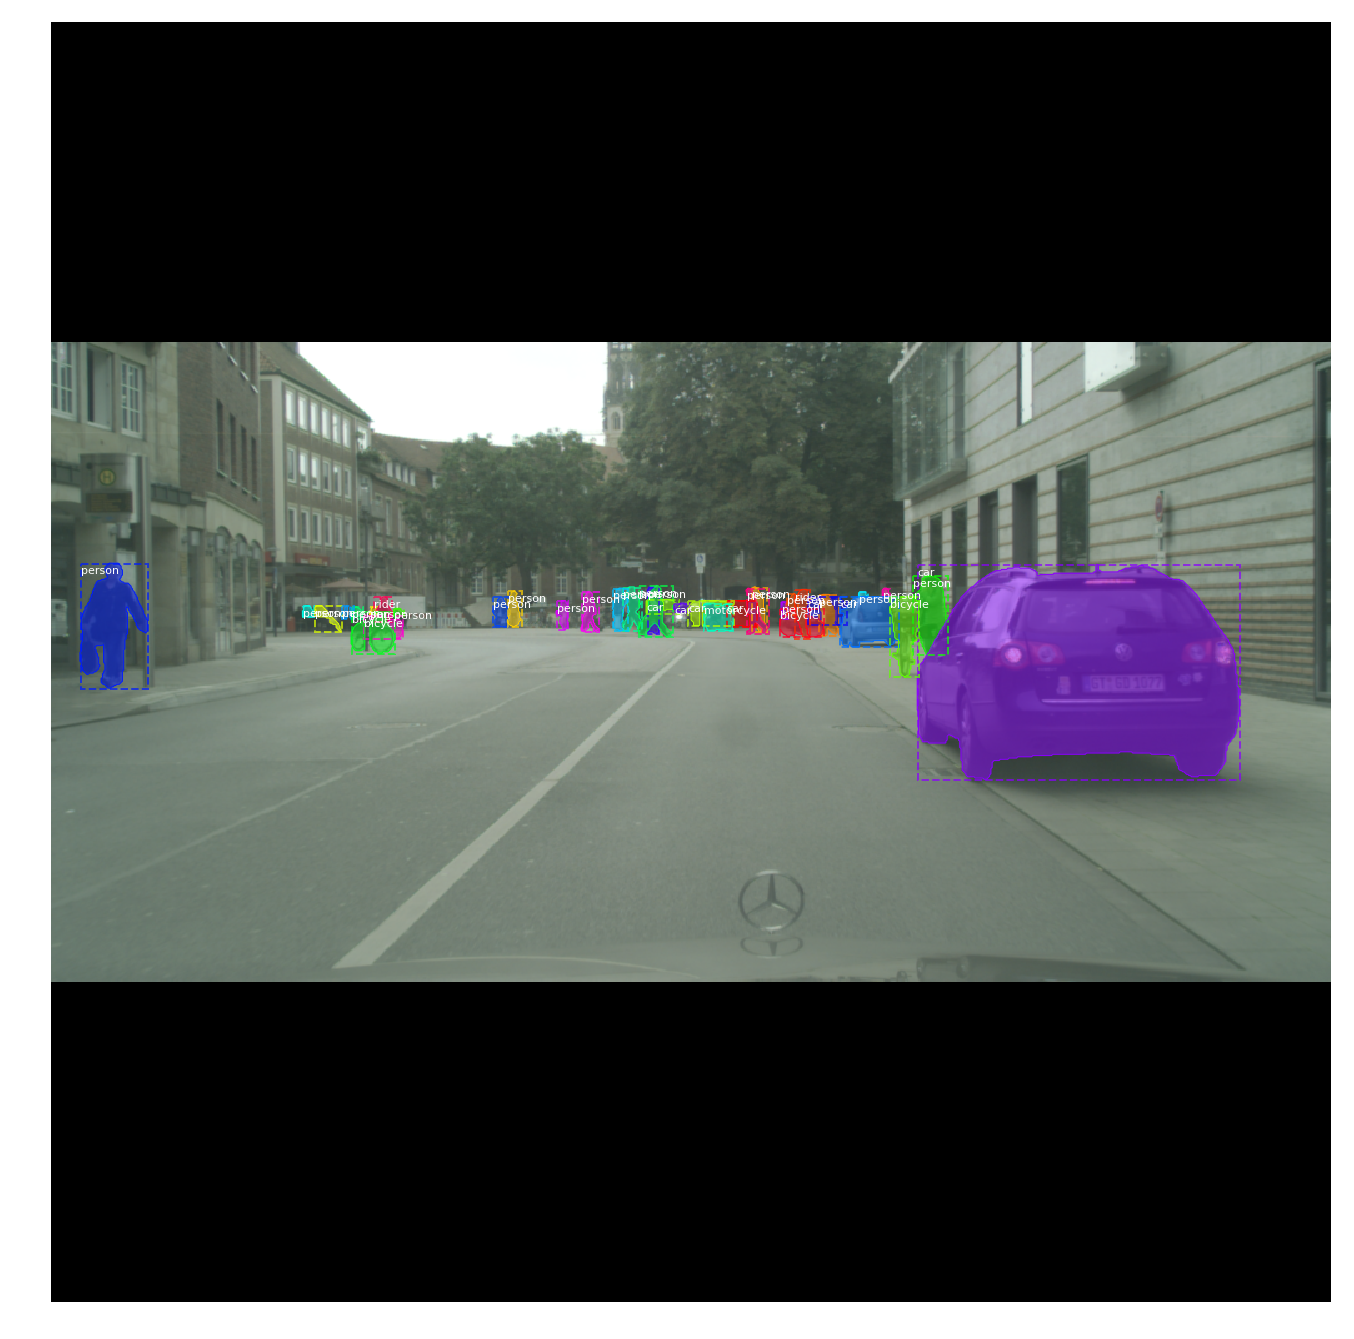

In [90]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, ax=get_ax(size=24), figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min:  -83.21195  max:  182.21956
image_metas              shape: (1, 29)               min:    0.00000  max: 1024.00000


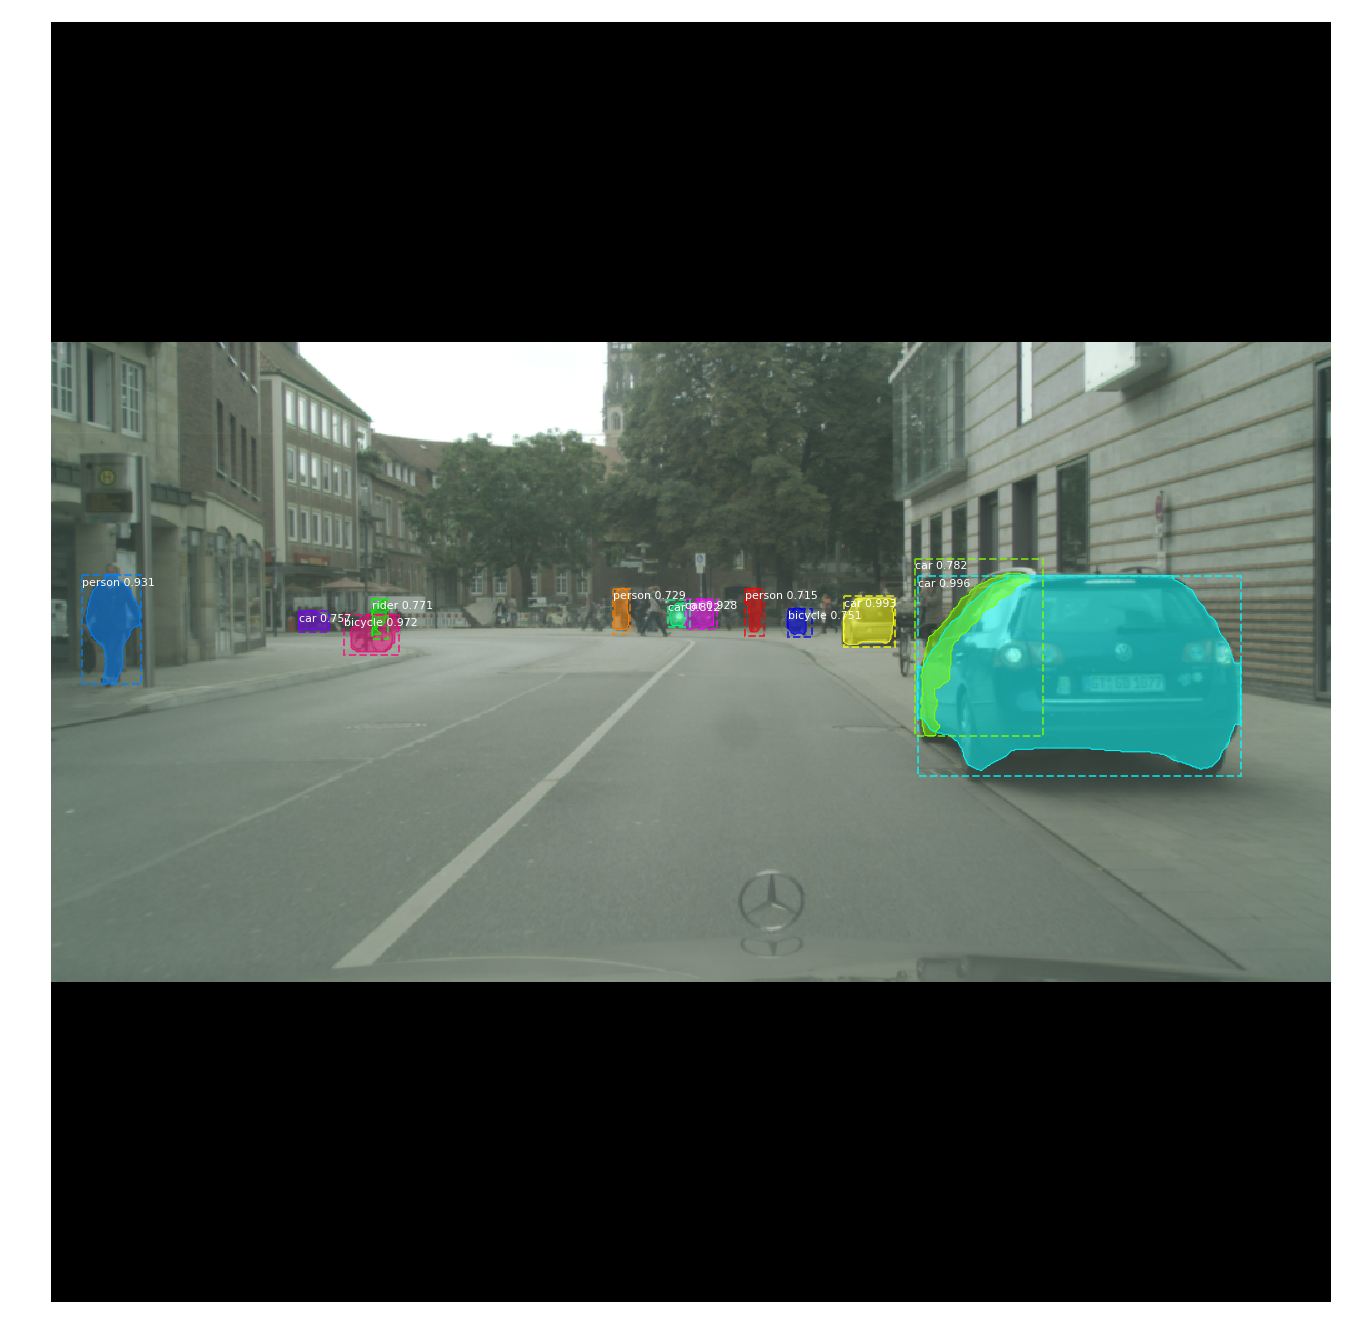

In [91]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(size=24))

## Evaluation

In [92]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.503473698128
